In [1]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
import matplotlib.pyplot as plt

from utils import normsq, single_rbf, pairwise_distances

# SVGD

## Update
Let's define the update rule.

In [2]:
def phi_j(x, y, logp, kernel):
    """
    IN: 
    x and y are arrays of length d
    kernel is a callable that computes the kernel k(x, y, kernel_params)
    logp is the log of a differentiable pdf p
    
    OUT: 
    \nabla_x log(p(x)) * k(x, y) + \nabla_x k(x, y)
    
    that is, phi(x_i) = \sum_j phi_j(x_j, x_i)
    """
    assert x.ndim == 1 and y.ndim == 1
    return grad(logp)(x) * kernel(x, y) + grad(kernel)(x, y)

phi_j_batched = vmap(phi_j, (0, 0, None, None), 0)

def update(x, logp, stepsize, kernel_params):
    """
    IN:
    x is an np array of shape n x d
    logp is the log of a differentiable pdf p
    stepsize is a float
    kernel_params are a set of parameters for the kernel
    
    OUT:
    xnew = x + stepsize * \phi^*(x)
    that is, xnew is an array of shape n x d. The entries of x are the updated particles.
    
    note that this is an inefficient way to do things, since we're computing k(x, y) twice for each x, y combination.
    """
    assert x.ndim == 2
    kernel = lambda x, y: single_rbf(x, y, kernel_params)
#     kerneltest = lambda x, y: np.exp(- normsq(x - y) / (2 * kernel_params ** 2))
#     assert kerneltest(x[0], x[1]) == kernel(x[0], x[1])
    
    xnew = []
    n = x.shape[0]
    for i, xi in enumerate(x):
        repeated = np.tile(xi, (n, 1))
        xnew.append(stepsize * np.sum(phi_j_batched(x, repeated, logp, kernel), axis = 0))
    xnew = np.array(xnew)
    xnew += x

    return xnew

update = jit(update, static_argnums=(1,)) # logp is static

To accelerate the function `update` with `jit` we had to use the `static_argnums` argument. This is because `jit` only knows how to deal with functions that are 1) pure, that is no side effects, and 2) take only np arrays as inputs and outputs.

In effect, the `static_argnums` argument tells `jit` to ignore the callable input `logp`. Everytime it changes, `jit` recompiles.

## SVGD

In [3]:
def svgd(x, logp, stepsize, kernel_params, L, update_kernel_params=False, kernel_param_update_rule=None):
    """
    x is an np array of shape n x d
    logp is the log of a differentiable pdf p (callable)
    stepsize is a float
    kernel is a differentiable function k(x, y, h) that computes the rbf kernel (callable)
    L is an integer (number of iterations)
    
    if update_kernel_params is True, then kernel_param_update_rule must be given.
    kernel_param_update_rule is a callable that takes xnew as input and outputs an updated set of kernel parameters.
    
    OUT:
    Updated particles x (np array of shape n x d) after L steps of SVGD
    """
    assert x.ndim == 2
    log = {
        "kernel_params": [kernel_params],
        "particle_mean": [np.mean(x)],
        "particle_var": [np.var(x)]
    }

    for i in range(L):
        x = update(x, logp, stepsize, kernel_params)
        log["particle_mean"].append(np.mean(x))
        log["particle_var"].append(np.var(x))
        
        if np.any(np.isnan(x)):
            raise ValueError(f"NaN produced at iteration {i}")
        if update_kernel_params:
            kernel_params = kernel_param_update_rule(x)
            log["kernel_params"].append(kernel_params)
        
    return x, log

# Sample
## Experiment 1: one-dim Gaussian mixture

### Experiment 1.1
Target distribution:
$$ p(x) = \mathcal N(x; 0, 1) $$
Initialization:
$$ q_0(x) = \mathcal N(x; -10, 1) $$
Kernel bandwidth:
$$ h = \text{med}^2 / \log n, $$
where med is the median of the $ n \choose 2$ pairwise distances between the points $x_1, \dots, x_n$. Important to note: the bandwidth here changes adaptively across iterations.

In [4]:
from jax.scipy.stats import norm

@jit
def kernel_param_update_rule(x):
    assert x.ndim == 2
    n = x.shape[0]
    
    h = np.median(pairwise_distances(x))**2 / np.log(n)
    return h

@jit
def logp(x):
    """
    IN: single scalar np array x. alternatively, [x] works too
    OUT: scalar logp(x)
    """
    out = norm.logpdf(x, loc=0, scale=1)
    return np.squeeze(out) # to be able to take a gradient, output must be scalar

In [5]:
# # works with:
# n = 20
# d = 1
# stepsize = 0.1
# L = 10

# experiment:
n = 20
d = 1
stepsize = 0.001
L = int(1 / stepsize)

# generate data
key = random.PRNGKey(0)
x0 = random.normal(key, (n,d))
x0 = x0 - 10 # sampled from q_0
x = x0
h = kernel_param_update_rule(x)

xout, log = svgd(x, logp, stepsize, h, L, update_kernel_params=True, kernel_param_update_rule=kernel_param_update_rule)
print(xout.shape)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:122: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


(20, 1)


## Diagnostics

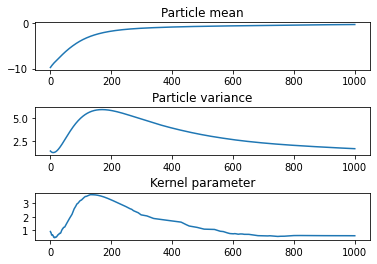

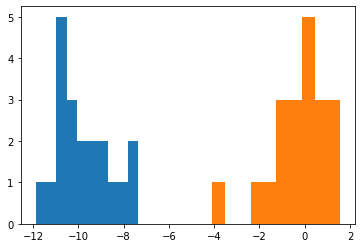

In [6]:
plt.figure(1)
plt.subplots_adjust(hspace=0.8)


plt.subplot(311) # 2 plots on 0th axis, 1 plot on 1th axis, plot nr 1 --> 211
plt.title("Particle mean")
plt.plot(log["particle_mean"])


plt.subplot(312)
plt.title("Particle variance")
plt.plot(log["particle_var"])

plt.subplot(313)
plt.title("Kernel parameter")
plt.plot(log["kernel_params"])


plt.figure(2)
_ = plt.hist(x0[:, 0])
_ = plt.hist(xout[:, 0])

In [7]:
min(log["kernel_params"])

DeviceArray(0.41672626, dtype=float32)

In [7]:
# print("x0 shape: ", x0.shape)
# print("x shape: ", xout.shape)
# print()

# print("x0 mean: ", np.mean(x0))
# print("x mean: ", np.mean(xout))
# print()

# print("x0 var: ", np.var(x0))
# print("x var: ", np.var(xout))
# print()

Now let's see what speedup `jit` gets us.

In [8]:
%timeit svgd(x, logp, stepsize, h, L, update_kernel_params=True, kernel_param_update_rule=kernel_param_update_rule)

1.62 s ± 148 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


* With jitted `update`: 12.2 ms per loop
* Without jitted `update`: 1.08 s per loop

So that's a speedup of around 100x. Sweet!

### Experiment 1.2
Target distribution:
$$ p(x) = 1/3 \mathcal N(-2, 1) + 2/3 \mathcal N(2, 1) $$
Initialization:
$$ q_0(x) = \mathcal N(-10, 1) $$
Kernel bandwidth:
$$ h = \text{med}^2 / \log n, $$
where med is the median of the $ n \choose 2$ pairwise distances between the points $x_1, \dots, x_n$. Important to note: the bandwidth here changes adaptively across iterations.

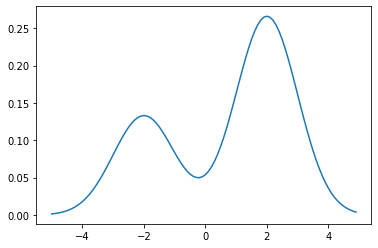

In [39]:
from jax.scipy.stats import norm

@jit
def kernel_param_update_rule(x):
    assert x.ndim == 2
    n = x.shape[0]
    
    h = np.median(pairwise_distances(x))**2 / np.log(n)
    return h

def p(x):
    """
    IN: single scalar np array x. alternatively, [x] works too
    OUT: scalar logp(x)
    """
    out = 1/3 * norm.pdf(x, loc=-2, scale=1) + 2/3 * norm.pdf(x, loc=2, scale=1)
    return np.squeeze(out) # to be able to take a gradient, output must be scalar

grid = np.arange(-5, 5, 0.1)
_ = plt.plot(grid, p(grid))

def logp(x):
    return np.log(p(x))

In [40]:
# experiment:
n = 100
d = 1
stepsize = 0.001
L = int(1 / stepsize)

# generate data
key = random.PRNGKey(10)
x0 = random.normal(key, (n,d))
x0 = x0 - 10 # sampled from q_0
x = x0
h = kernel_param_update_rule(x)

xout, log = svgd(x, logp, stepsize, h, L, update_kernel_params=True, kernel_param_update_rule=kernel_param_update_rule)

## Diagnostics

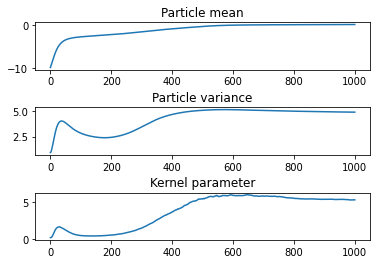

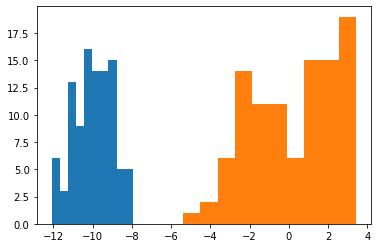

In [41]:
plt.figure(1)
plt.subplots_adjust(hspace=0.8)


plt.subplot(311) # 2 plots on 0th axis, 1 plot on 1th axis, plot nr 1 --> 211
plt.title("Particle mean")
plt.plot(log["particle_mean"])


plt.subplot(312)
plt.title("Particle variance")
plt.plot(log["particle_var"])

plt.subplot(313)
plt.title("Kernel parameter")
plt.plot(log["kernel_params"])

plt.figure(2)
_ = plt.hist(x0[:, 0])
_ = plt.hist(xout[:, 0])

In [42]:
log["particle_mean"][-1]

DeviceArray(0.21698934, dtype=float32)

In [43]:
## test functions
mse1 = (np.mean(xout) - 2/3)**2
mse2 = (np.mean(xout**2) - 5)**2
print(mse1)
print(mse2)

0.20220971
0.0024551137


# Experiment 2: Bayesian logistic regression